# Most basic example
---
In this example we are just going to try a fairly simple FeedForward Neural Net. We're just going to try and wing it to see where we end-up. This will serve as a sort of base-line for the rest of the tests.

Before we start maybe a small remark on the Merchant-id. You'd be excused for thinking that including the merchant id in these tests is a mistake. For one it has a lot of correlation with the category code and secondly Merchant-id's could in real life be a piece of data that is way too specific. 

Data that has high cardinality (i.e. is very specific) might trigger a model to start memorizing during training instead of generalizing. Broadly speaking you want to avoid giving NN's data that is too specific, like transaction-ids, exact timestamps etc.... 

It turns out that if you remove the Merchant-id, the models have a much harder time finding the fraud, they'll drag-in a massive amount of false positives. Agruably, this is realistic. The risk of a model a small as this over fitting seemed rather small and in further netebooks we'll try Embeddings so the model needs to focus on certain aspects of the merchant rather than the Merchant-id, so let's keep it for now, realizing in real-life you might not.

## Requirements
Before running the experiment, make sure to import the `numpy`, `pandas` and `numba`, `torch`, `tqdm`, `matplotlib`, `scikit-learn`, `captum` packages in your virtual environment
```
> pip install numpy
> pip install pandas
> pip install numba
> pip install torch
> pip install tqdm
> pip install matplotlib
> pip install scikit-learn
> pip install captum
```
And that the notebook can find the `f3atur3s`, `eng1n3` and `m0d3l` packages.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import f3atur3s as ft
import eng1n3.pandas as en
import m0d3l.pytorch as mp
import m0d3l.plot as mplt
import m0d3l.captum as cp

from captum.attr import IntegratedGradients

from typing import Tuple

/home/toms/Jupyter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set a random seed for Numpy and Torch
Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
## Set up the devices, on from the data and one for modeling.
data_device  = torch.device('cpu')
model_device = torch.device('cuda') if torch.cuda.is_available() else data_device

## File Location
Change this to read from another location

In [4]:
file = '../../../../data/bs140513_032310.csv'

## Define Features
Most of the referential features have been set-up as a `FeatureOneHot` which will make our models encode them as a **OneHot** vector, the amount has been scaled between 0 and 1.

In [5]:
# Base Features
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

# Continuous Features
amount_scale = ft.FeatureNormalizeScale('amount_scale', ft.FEATURE_TYPE_FLOAT_32, amount, log_base='e')
# Categorical Features
age_oh = ft.FeatureOneHot('age_oh', ft.FEATURE_TYPE_INT_8, age)
gender_oh = ft.FeatureOneHot('gender_oh', ft.FEATURE_TYPE_INT_8, gender)
merchant_oh = ft.FeatureOneHot('merchant_oh', ft.FEATURE_TYPE_INT_16, merchant)
category_oh = ft.FeatureOneHot('category_oh', ft.FEATURE_TYPE_INT_16, category)
# Label Feature
fraud_label = ft.FeatureLabelBinary('fraud_label', ft.FEATURE_TYPE_INT_8, fraud)

# TensorDefinitions
td_oh          = ft.TensorDefinition('one-hot', [age_oh, gender_oh, merchant_oh, category_oh])
td_continuous  = ft.TensorDefinition('continuous', [amount_scale])
td_label       = ft.TensorDefinition('label', [fraud_label])

with en.EnginePandas() as e:
    ti = e.np_from_csv((td_continuous, td_oh, td_label), file, inference=False)

print(ti.shapes)
print(ti.dtype_names)

2023-04-25 14:35:16.931 eng1n3.common.engine           INFO     Start Engine...
2023-04-25 14:35:16.932 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-04-25 14:35:16.932 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-04-25 14:35:16.933 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../data/bs140513_032310.csv
2023-04-25 14:35:17.297 e...renormalizescaleprocessor  INFO     Create amount_scale Scale amount. Min. -4.61 Max. 9.03
2023-04-25 14:35:17.317 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-04-25 14:35:17.327 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 3 numpy arrays


((594643, 1), (594643, 77), (594643, 1))
('float32', 'uint8', 'int8')


## Create Data-Sets and Loaders

In [6]:
train, val, test = ti.split_sequential(30000, 100000)

batch_size = 128
# Creating DataSets
train_ds = mp.TensorInstanceNumpyDataSet(train)
val_ds   = mp.TensorInstanceNumpyDataSet(val)
test_ds  = mp.TensorInstanceNumpyDataSet(test)

# Creating an oversampler for the training set.
train_sampler = mp.TensorInstanceNumpyLabelSampler.over_sampler(train)

# Setting up the Dataloaders.
train_dl = train_ds.data_loader(data_device, batch_size, num_workers=2, sampler=train_sampler)
val_dl   = val_ds.data_loader(data_device, batch_size, num_workers=2)
test_dl  = test_ds.data_loader(data_device, batch_size, num_workers=2)

print(train.shapes)
print(val.shapes)
print(test.shapes)

((464643, 1), (464643, 77), (464643, 1))
((30000, 1), (30000, 77), (30000, 1))
((100000, 1), (100000, 77), (100000, 1))


## Define a Model Class

In [7]:
class BankSimFeedForwardModel(mp.BinaryClassifier):
    def __init__(self, model_configuration: mp.ModelConfiguration):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(BankSimFeedForwardModel, self).__init__(model_configuration)
        
        # Create the heads, they are the first layer of the NN.
        self.heads = self.create_heads()
        heads_size = sum([h.output_size for h in self.heads])
        
        # Set of layers
        self.layers = mp.LinLayer(input_size=heads_size, layer_sizes=(16,8), dropout=0.0, bn_interval=2)
        
        # One Linear Layer that maps the output of the heads
        self.l1 = nn.Linear(in_features=self.layers.output_size, out_features=1)
        
        # And a tail layer, for a binary classifier this is a Sigmoid.
        self.tail = self.create_tail()

    # Create a forward-pass function through the neural net. Make sure to return a Tuple of Tensors!
    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        o = torch.cat([h(x[i]) for i, h in enumerate(self.heads)], dim=1)
        o = self.layers(o)
        o = self.l1(o)
        o = self.tail(o)
        return (o,)

#Create a model instance
model = BankSimFeedForwardModel(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
model

BankSimFeedForwardModel(
  Number of parameters : 1425. Loss : SingleLabelBCELoss,  mean
  (heads): ModuleList(
    (0): TensorDefinitionHead(Name=continuous, lc=Continuous)
    (1): TensorDefinitionHead(Name=one-hot, lc=Binary)
  )
  (layers): LinLayer(
    (layers): Sequential(
      (lin_layer_01): Linear(in_features=78, out_features=16, bias=True)
      (lin_act_01): ReLU()
      (lin_layer_02): Linear(in_features=16, out_features=8, bias=True)
      (lin_bn_02): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (lin_act_02): ReLU()
    )
  )
  (l1): Linear(in_features=8, out_features=1, bias=True)
  (tail): Sigmoid()
)

This is what the model would look like visually. (Some Layers were omitted for simplicity)

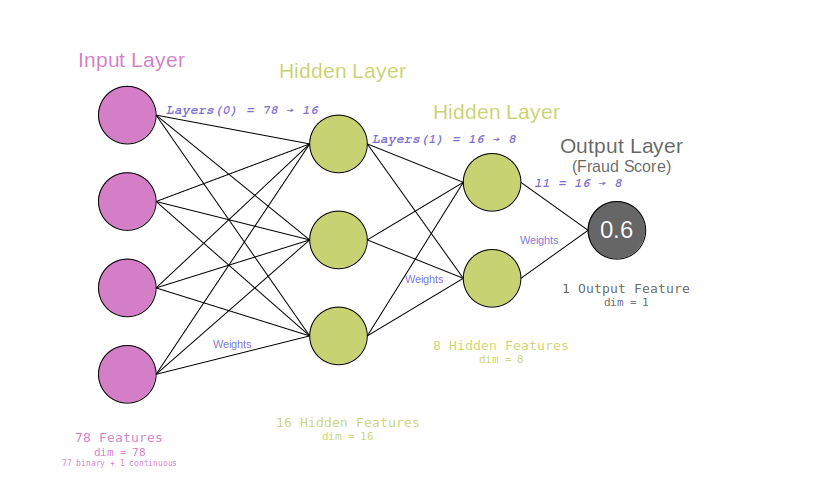

## Finding a Learning rate

Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 272.86it/s]                                                    


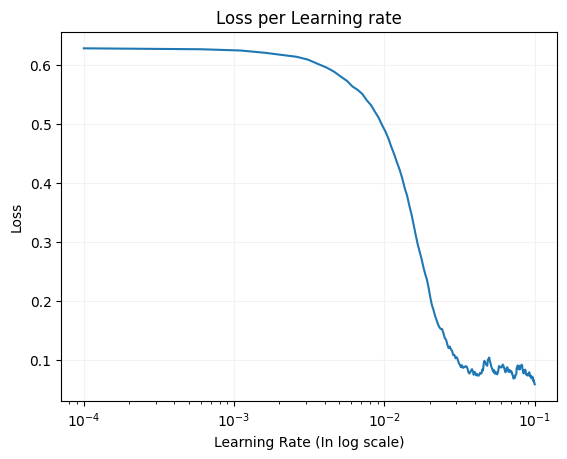

In [8]:
min_lr = 1e-4
max_lr = 1e-1
m_lr = BankSimFeedForwardModel(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
o_lr = mp.AdamWOptimizer(m_lr, lr=min_lr)
t_lr = mp.Trainer(m_lr, model_device, train_dl, val_dl)
lrs  = t_lr.find_lr(o_lr, max_lr, 200)
mplt.TrainPlot.plot_lr(lrs);

## Training
Run 10 epochs using a OneCycle LR scheduler

In [9]:
EPOCHS = 5

# First create a trainer.
trainer = mp.Trainer(model, model_device, train_dl, val_dl)
# Then an optimizer
optimizer = mp.AdamWOptimizer(model, lr=8e-3)
# Set up a OneCycle Scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer.optimizer, 
            max_lr=optimizer.lr,
            steps_per_epoch=trainer.number_of_train_steps,
            epochs=EPOCHS
)

# Run the trainer for [EPOCH] epochs
history = trainer.train(EPOCHS, optimizer, scheduler)

Epoch 005/005: 100%|██████████| 3866/3866 [00:04<00:00, 899.80it/s, t_loss=0.051, t_acc=0.979, v_loss=0.0366, v_acc=0.982]     


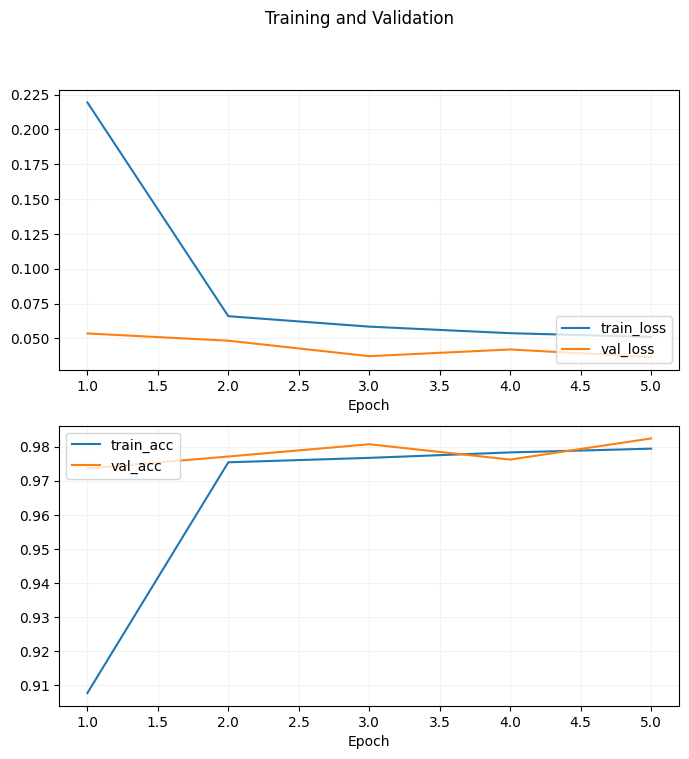

In [10]:
mplt.TrainPlot.plot_history(history, fig_size=(8,8));

## Testing the model

Testing in 782 steps: 100%|█████████████████| 782/782 [00:00<00:00, 1436.56it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     98926
         1.0       0.41      0.98      0.58      1074

    accuracy                           0.98    100000
   macro avg       0.71      0.98      0.79    100000
weighted avg       0.99      0.98      0.99    100000


auc score : 0.9986
ap score  : 0.9176
-----------------------------------------------------


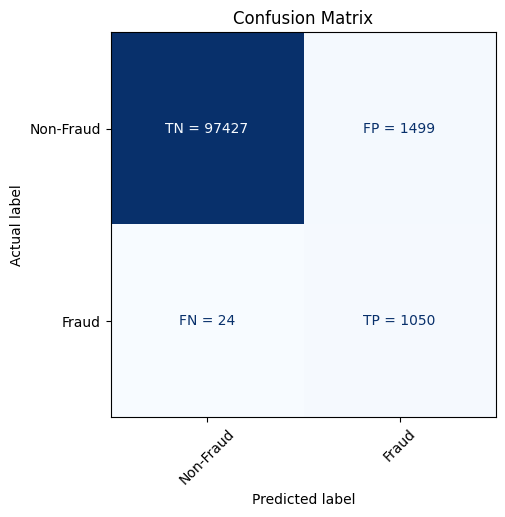

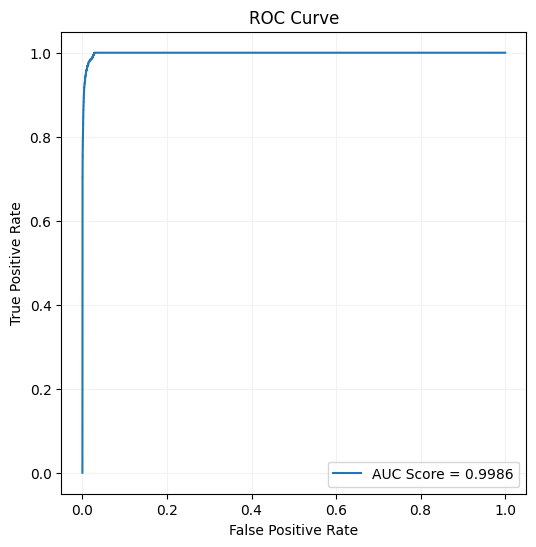

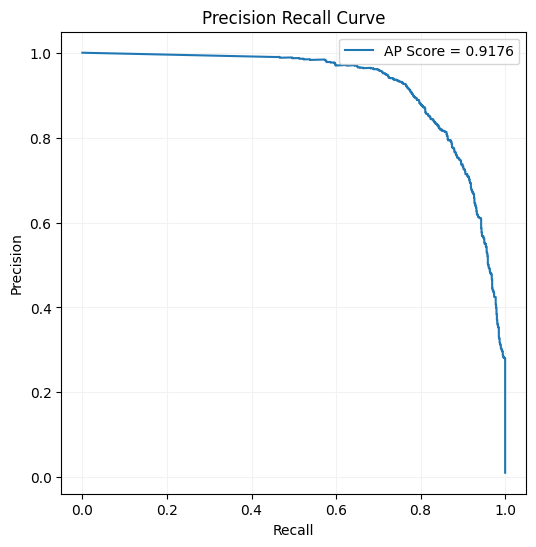

In [11]:
t = mp.Tester(model, model_device, test_dl)
results = t.test_results_binary()
mplt.TestPlot.print_binary_classification_report(results)
mplt.TestPlot.plot_binary_confusion_matrix(results, fig_size=(5,5));
mplt.TestPlot.plot_roc_curve(results, fig_size=(6,6));
mplt.TestPlot.plot_precision_recall_curve(results, fig_size=(6,6))

## Feature Attribution

In [12]:
attr = cp.CaptumAttributions.get_attributions_binary(
    model, ti.target_tensor_def, model_device, IntegratedGradients, test_ds[0:5000]
)

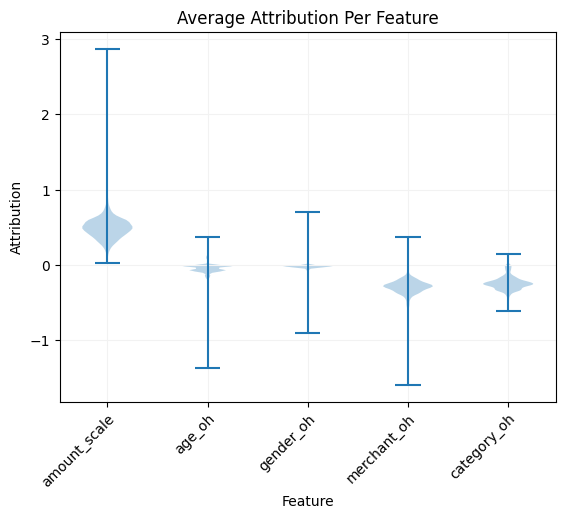

In [13]:
mplt.AttributionPlotBinary.overview(attr)

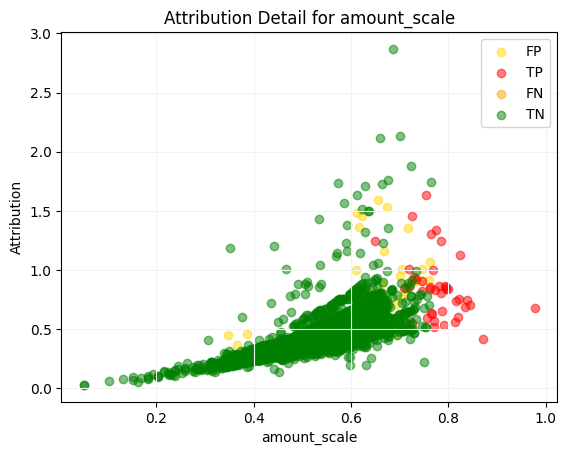

In [14]:
mplt.AttributionPlotBinary.feature_detail(attr, amount_scale)

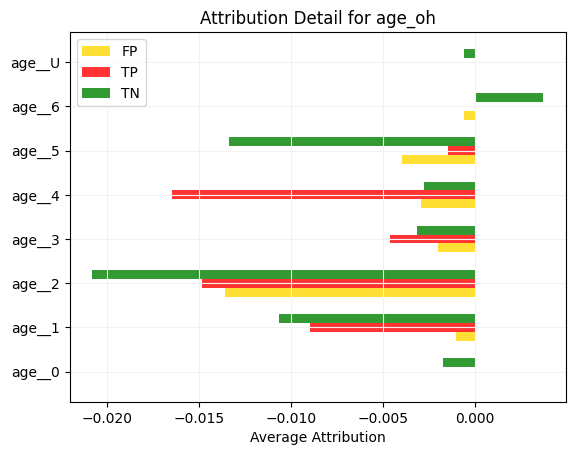

In [15]:
mplt.AttributionPlotBinary.feature_detail(attr, age_oh)

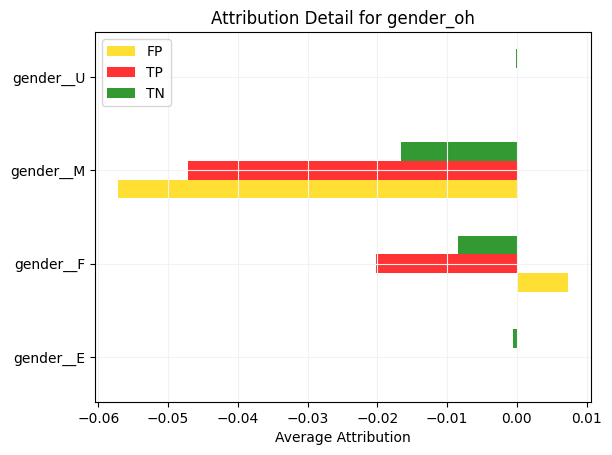

In [16]:
mplt.AttributionPlotBinary.feature_detail(attr, gender_oh)

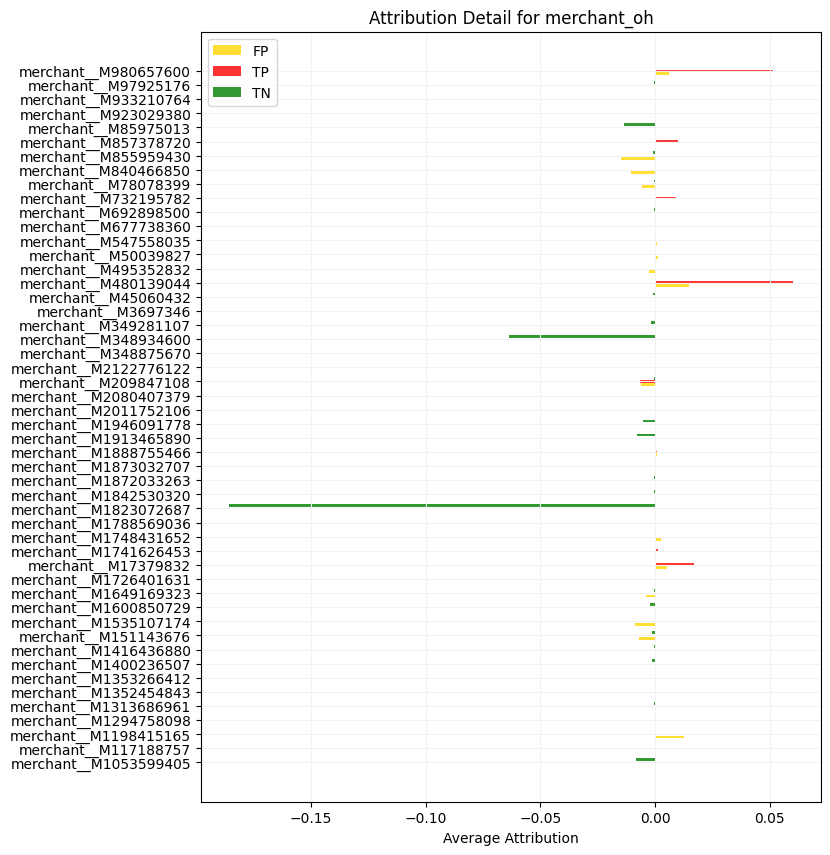

In [17]:
mplt.AttributionPlotBinary.feature_detail(attr, merchant_oh, fig_size=(8,10))

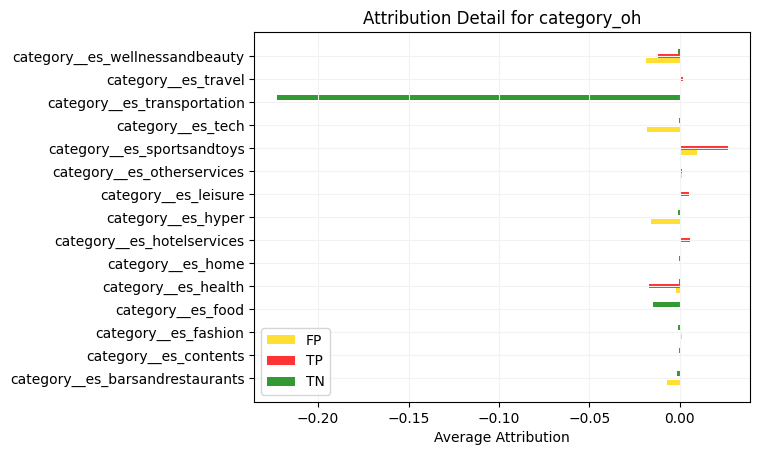

In [18]:
mplt.AttributionPlotBinary.feature_detail(attr, category_oh)

## Conclusion
We create a first very simple model, the training was maybe a bit handwavy, but it gives us a sort of baseline of what a simple NN is able to detect on single input records.